In [ ]:
%%bash
data = cd ../../../datag/blpd0/datax/Voyager_data
ls

bash: line 1: cd: ../../../datag/blpd0/datax/Voyager_data: No such file or directory


blimpy_voyager.ipynb
test.png


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from tabulate import tabulate
from astropy.time import Time
from tqdm import tqdm
import csv

In [3]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    uniqude_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    
    plt.tight_layout()


signal_power was heavily interfering with clustering 602 -> 292


Total filtered hits: 114806


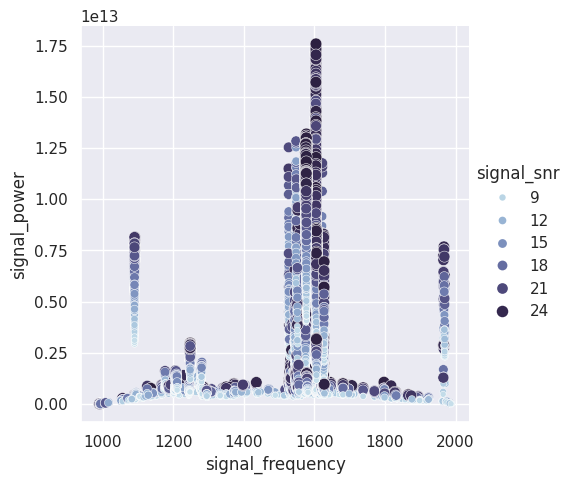

In [4]:
#signal power to frequency to noise relationships
def processing(file,start,stop):
    df = pd.read_pickle(f"/datag/users/ctremblay/{file}")
    small_df = df[start:stop]
    columns=['file_uri','source_name','beam_id','ra_hours' , 'dec_degrees' , 'tstart','signal_frequency', 'signal_beam', 
             'signal_drift_rate', 'signal_snr' , 'signal_power' , 'signal_incoherent_power']
    df_new= small_df[columns]
    #filter through hits based on reasonable thresholds 
    df_new = df_new[(df_new['signal_drift_rate'] != 0) & 
                    (df_new['signal_snr'] <= 25) & 
                    (df_new['signal_beam'] <= 3)]

    print(f"Total filtered hits: {len(df_new)}")

    unique_uris = df_new['file_uri'].unique()

    for i, uri in enumerate(unique_uris):
        fov_subset = df_new[df_new['file_uri'] == uri]
        
    grouped_time = df_new.groupby("tstart")

    time_dfs={}
    for t_value, val_df in grouped_time:
        time_dfs[t_value] = val_df  # Save entire group DataFrame

    for t_value, df in time_dfs.items():
        freq_counts = df['signal_frequency'].value_counts()
        overlapping_freqs = freq_counts[freq_counts > 1]
        #if not overlapping_freqs.empty:
           # print(f"Time: {t_value} — {len(overlapping_freqs)} overlapping frequencies")
        for freq in overlapping_freqs.index:
            hits = df[df['signal_frequency'] == freq]
            #print(f"  Frequency {freq} seen in beams:", hits['beam_id'].unique())


    sns.set_theme()
    sns.relplot(data=df_new, x=df_new["signal_frequency"], y=df_new["signal_power"], 
                hue=df_new["signal_snr"], size = df_new["signal_snr"], palette = "ch:s=.25,rot=-.25")
 
    plt.show()

    

processing('Summer_Project_RA9_Dec0.90.pkl', 0,1000000)


Total filtered hits: 114806


/tmp/ipykernel_3499862/2714552052.py:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fov_subset.loc[:, 'rfi_flag'] = fov_subset['rfi_flag'].fillna(False)
/tmp/ipykernel_3499862/2714552052.py:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fov_subset.loc[:, 'rfi_flag'] = fov_subset['rfi_flag'].fillna(False)
/tmp/ipykernel_3499862/2714552052.py:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, s

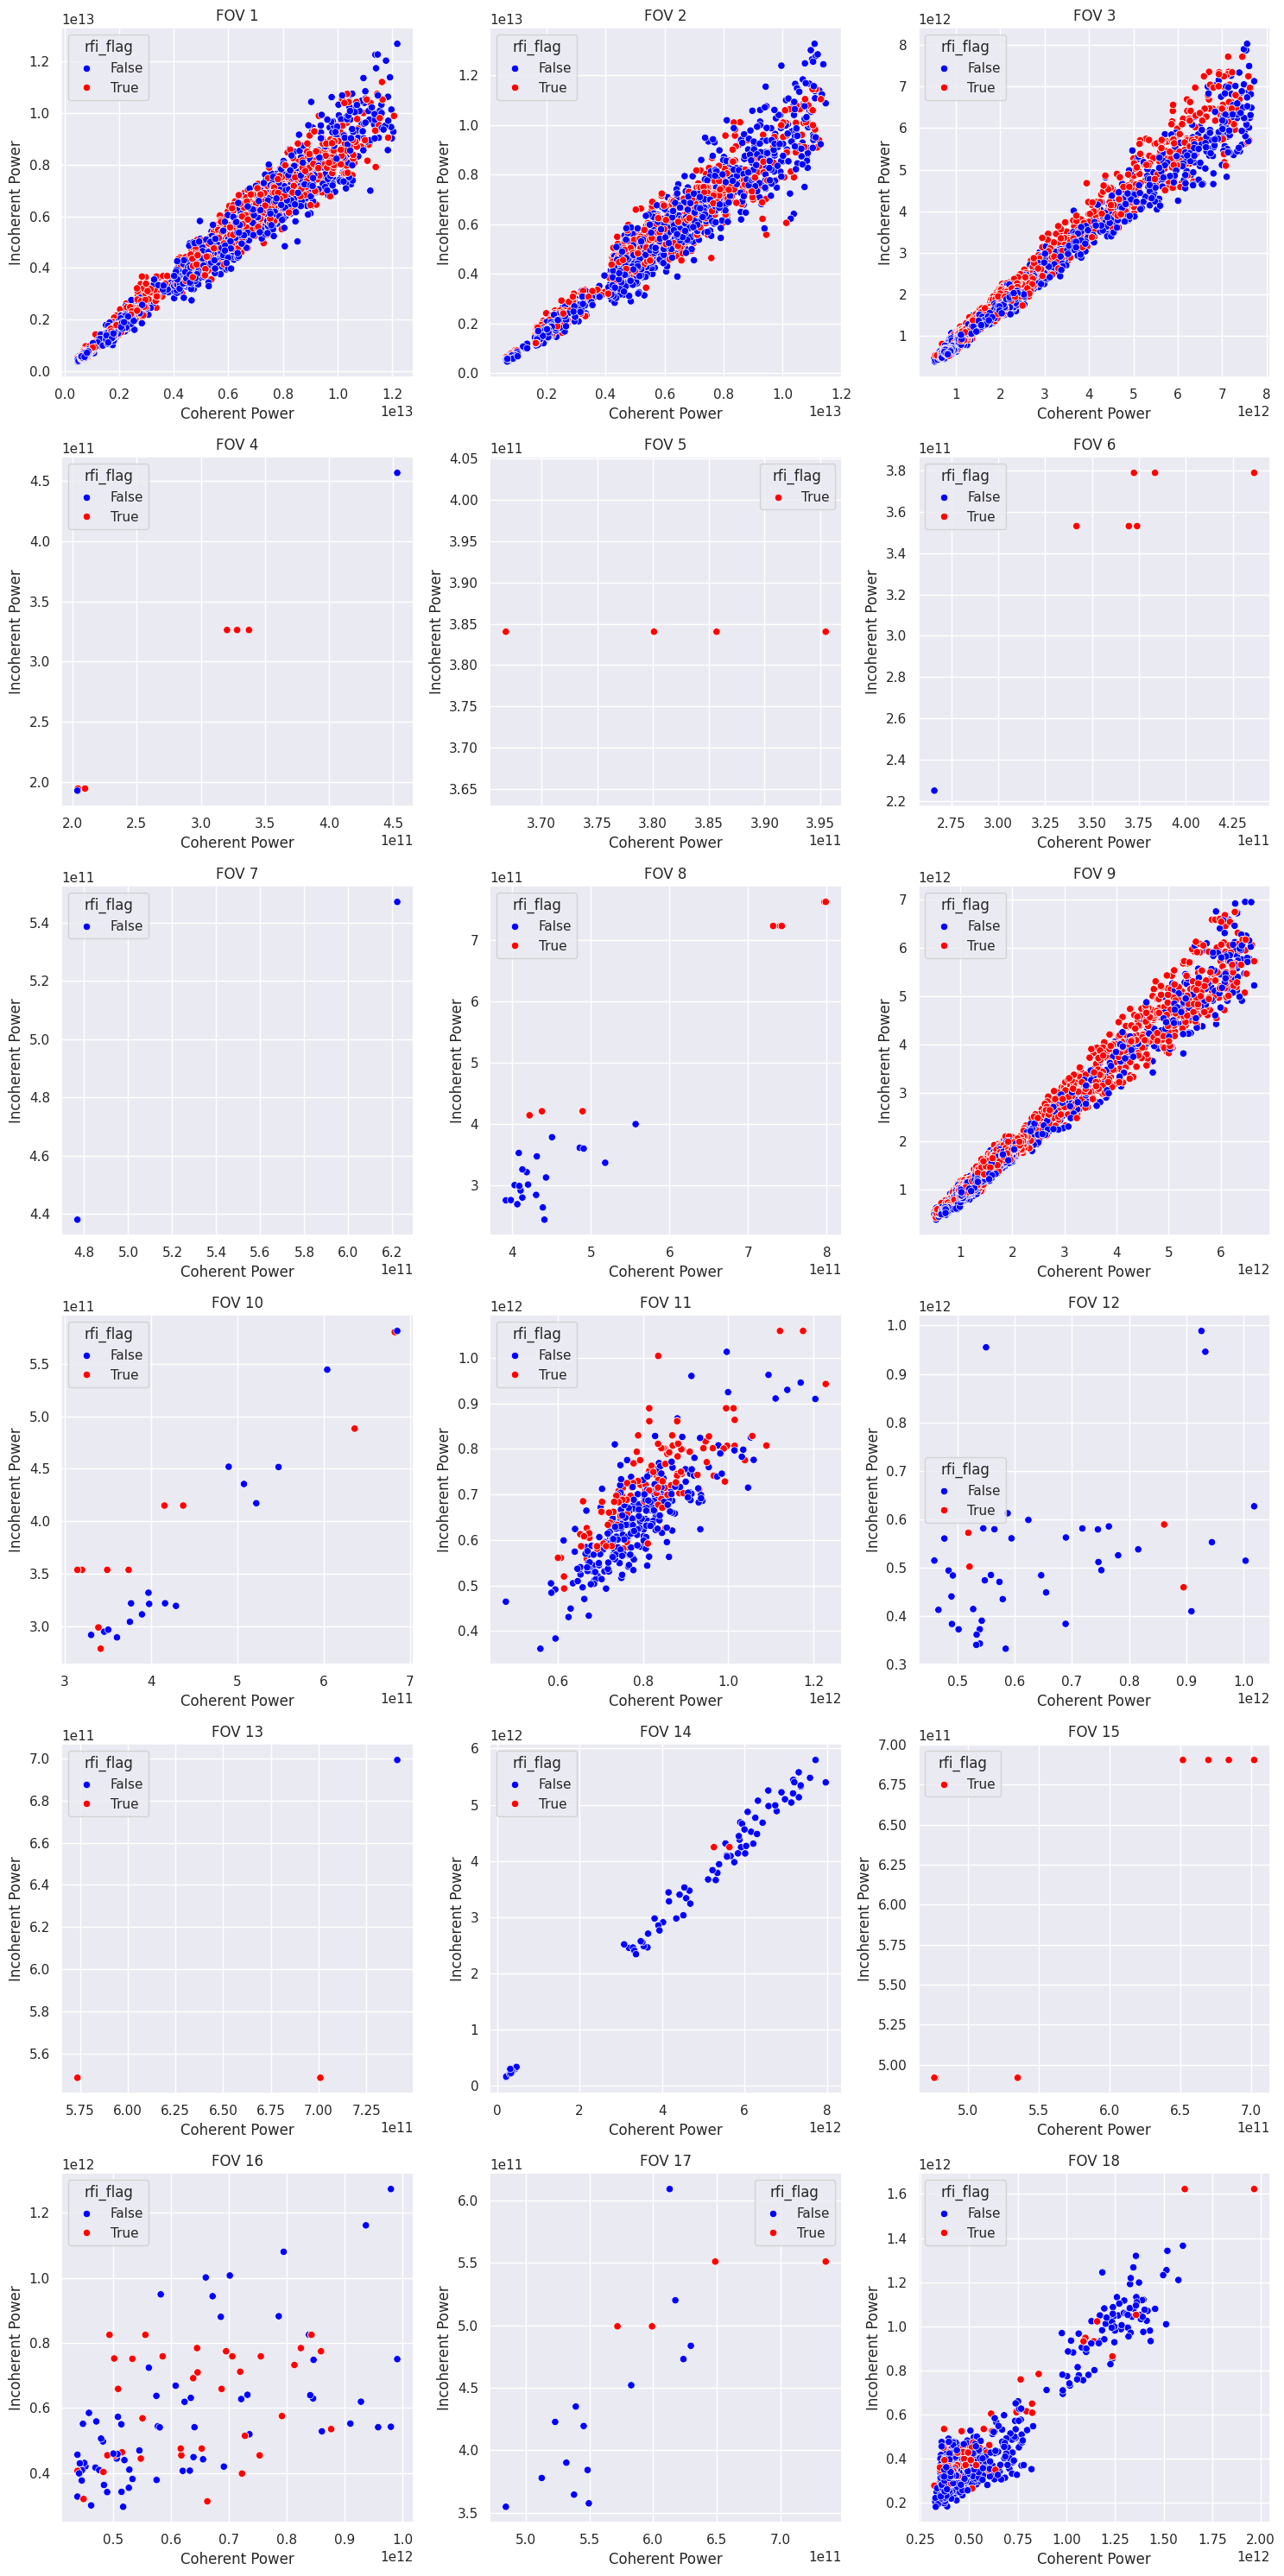

In [10]:
#incoherent to coherent power analysis 
def processing(file, start, stop, max_plots=0):
    global df_new
    # Load and slice dataset
    df = pd.read_pickle(f"/datag/users/ctremblay/{file}")
    small_df = df[start:stop]

    # Select relevant columns
    columns = ['file_uri', 'source_name', 'beam_id', 'ra_hours', 'dec_degrees', 'tstart',
               'signal_frequency', 'signal_beam', 'signal_drift_rate', 'signal_snr',
               'signal_power', 'signal_incoherent_power']
    df_new = small_df[columns]

    # Apply filtering thresholds
    df_new = df_new[(df_new['signal_drift_rate'] != 0) &
                    (df_new['signal_snr'] <= 25) &
                    (df_new['signal_beam'] <= 3)]

    print(f"Total filtered hits: {len(df_new)}")
    unique_uris = df_new['file_uri'].unique()

    # Set up subplot grid
    rows = int(np.ceil(max_plots / 3))
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, uri in enumerate(unique_uris):
        if i >= max_plots:
            break

        fov_subset = df_new[df_new['file_uri'] == uri].copy()  # copy to avoid SettingWithCopyWarning
        incoherent_power = np.unique(np.array(fov_subset["signal_incoherent_power"]))
        coherent_power = np.array(fov_subset["signal_power"])
        power_ratios_2_incoherent = []

        if len(incoherent_power) == 1:
            power_ratio = coherent_power[0]/incoherent_power[-1]
        
            if coherent_power[0]*4.4 > incoherent_power[-1]:
                power_ratios_2_incoherent.append(power_ratio)

                #appending_rows = data_fov_subset
                #df2 = df2.append(appending_rows, ignore_index = True)        

            else:
                continue
        
        overlapping_hits = []

        # Check for overlapping frequencies at same tstart
        grouped_time = fov_subset.groupby("tstart")
        for t_value, group_df in grouped_time:
            freq_counts = group_df['signal_frequency'].value_counts()
            overlapping_freqs = freq_counts[freq_counts > 1]
            for freq in overlapping_freqs.index:
                hits = group_df[group_df['signal_frequency'] == freq]
                overlapping_hits.append(hits)

        # Flag overlapping hits
        if overlapping_hits:
            rfi_df = pd.concat(overlapping_hits)
            rfi_df['rfi_flag'] = True
            fov_subset = fov_subset.merge(
                rfi_df[['signal_frequency', 'tstart', 'rfi_flag']],
                on=['signal_frequency', 'tstart'],
                how='left'
            )
            fov_subset.loc[:, 'rfi_flag'] = fov_subset['rfi_flag'].fillna(False)
        else:
            fov_subset['rfi_flag'] = False

        # Plot coherent vs. incoherent power
        ax = axes[i]
        sns.scatterplot(
            data=fov_subset,
            x='signal_power',
            y='signal_incoherent_power',
            hue='rfi_flag',
            ax=ax,
            palette={False: 'blue', True: 'red'}
        )
        ax.set_title(f"FOV {i+1}")
        ax.set_xlabel("Coherent Power")
        ax.set_ylabel("Incoherent Power")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

processing('Summer_Project_RA9_Dec0.90.pkl', 0,1000000, max_plots=18)


In [32]:
def processing(file,start,stop):
    df = pd.read_pickle(f"/datag/users/ctremblay/{file}")
    small_df = df[start:stop]
    columns=['source_name','beam_id','ra_hours' , 'dec_degrees' , 'tstart','signal_frequency', 'signal_beam', 
             'signal_drift_rate', 'signal_snr' , 'signal_power' , 'signal_incoherent_power']
    df_new= small_df[columns]
    #signal_drift_rate == 0 remove
    # S/R > 20 remove 
    grouped_dec = df_new.groupby("dec_degrees")

    dec_dfs={}
    for dec_value, group_df in grouped_dec:
        dec_dfs[dec_value] = group_df  # Save entire group DataFrame
        #print(len(group_df))
       # print(group_df.groupby("ra_hours").size())

    for i, (dec_value, df) in enumerate(dec_dfs.items(), start=1):
        globals()[f"fov_{i}"] = df
    print(len(fov_1))
    print(fov_1.groupby("tstart").size())

    return fov_1.head()
   # print(len(np.unique(df_new['signal_frequency'])))
   # print(df_new.groupby("tstart").size())
   # print(df_new.groupby("ra_hours").size())
   # print(df_new.groupby("signal_frequency").size())


    #return df_new

    

processing('Summer_Project_RA9_Dec0.90.pkl', 0,1000000)


167716
tstart
60069.113731     2230
60069.113829     3740
60069.113926     4634
60069.114411    15698
60069.114508    15110
60069.114605    15737
60069.114702    15544
60069.114799    10009
60069.114897    10796
60069.114994      436
60069.115091      186
60069.115188    14466
60069.115285    13646
60069.115382    13158
60069.115479    12895
60069.115576    11227
60069.115673     8204
dtype: int64


,source_name,beam_id,ra_hours,dec_degrees,tstart,signal_frequency,signal_beam,signal_drift_rate,signal_snr,signal_power,signal_incoherent_power
3,743517082989416704,32100,9.939133,28.7294,60069.113926,1990.883732,3,0.0,10.802960,1.297620e+10,1.243778e+10
22,743517082989416704,32100,9.939133,28.7294,60069.113926,1993.136731,3,0.0,13.276069,1.221296e+10,1.136826e+10
241,743517082989416704,32100,9.939133,28.7294,60069.113926,1572.756985,3,0.0,16.291704,1.014853e+12,9.275462e+11
243,743517082989416704,32100,9.939133,28.7294,60069.113926,1572.697094,3,0.0,9.456708,6.825698e+11,6.960990e+11
245,743517082989416704,32100,9.939133,28.7294,60069.113926,1572.713986,3,0.0,11.549982,7.843343e+11,6.280134e+11


(2960, 10)
463


NameError: name 'unique_labels' is not defined

<Figure size 1000x600 with 0 Axes>

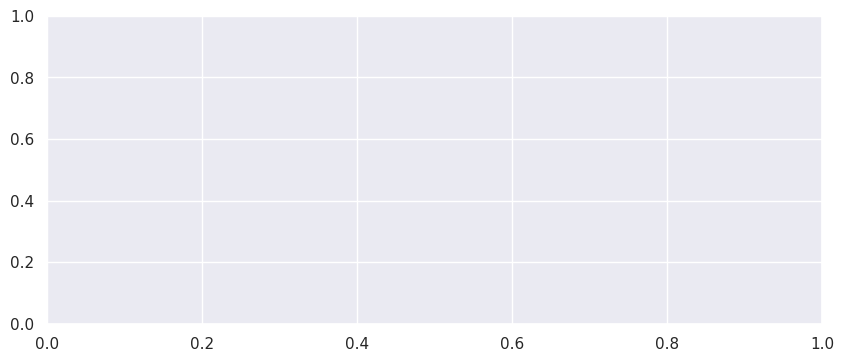

In [7]:
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



%matplotlib inline
plt.figure(figsize=(10,6))

# 1. Prepare full-dimensional numeric data
X = df_new.select_dtypes(include=[np.number]).fillna(0).values
print(X.shape)

# 2. Fit HDBSCAN
clusterer = HDBSCAN(min_cluster_size=10, n_jobs=-1)
clusterer.fit(X)
labels = clusterer.labels_
probabilities = getattr(clusterer, "probabilities_", None)
print(np.count_nonzero(np.where(labels==-1)))

# 3. Project to 2D for visualization
X_2d = PCA(n_components=2).fit_transform(X)

# 4. Plot clusters
plot(X_2d, labels, probabilities=probabilities, parameters={"min_cluster_size":10})
plt.show()
